# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

👍 Цели, задачи и план ясны.
</div>
 

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

👍 Тихая загрузка)
</div>
 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import time
import phik

## Подготовка данных

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df_shape = df.shape[0]
df.info()
display(df.head(15))
print(df_shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


354369


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Признаки `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode` и `LastSeen` являются неинфоративными и их можно удалить.**

In [4]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'], axis = 1)

**Переименуем столбцы по стандарту.**

In [5]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',\
              'fuel_type', 'brand', 'repaired']

**Столбцы `repaired`, `vehicle_type`, `fuel_type`, `gearbox` и `model` имеют пропуски, посмотрим.**

In [6]:
df.isna().sum().sort_values(ascending=False)

repaired             71154
vehicle_type         37490
fuel_type            32895
gearbox              19833
model                19705
price                    0
registration_year        0
power                    0
kilometer                0
brand                    0
dtype: int64

**В столбце `repaired` пропуски, скорее всего, означают автомобиль не ремонтировался или продавец специально не указал информацию, чтобы скрыть факт ремонта. Заменим пустые значения на `unknown`**

In [7]:
df['repaired'] = df['repaired'].fillna('unknown')

**В столбце `vehicle_type` пропуски, скорее всего, появились из-за невнимательности или незнании автора объявления о типе кузова своего авто, а, может, просто не стал указывать. Заменим пустые значения на `unknown`**

In [8]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

**Заполним пропуски в столбцах `fuel_type`, `model` и `gearbox` заглушками `unknown`.**

In [9]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna('unknown')

In [10]:
df.isna().sum().sort_values(ascending=False)

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [11]:
cat_columns = df.select_dtypes(include='object').columns.tolist()
num_columns = df.select_dtypes(include='int').columns.tolist()

In [12]:
for column in cat_columns:
    print(df[column].unique())
print('Количество явных дубликатов:', df.duplicated().sum())

['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
['manual' 'auto' 'unknown']
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max

**Кроме явных дубликатов есть 1 неявный дубликат: `range_rover` и `rangerover` в признаке `model`**

In [13]:
df['model'] = df['model'].replace('rangerover', 'range_rover')
df = df.drop_duplicates().reset_index(drop=True)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


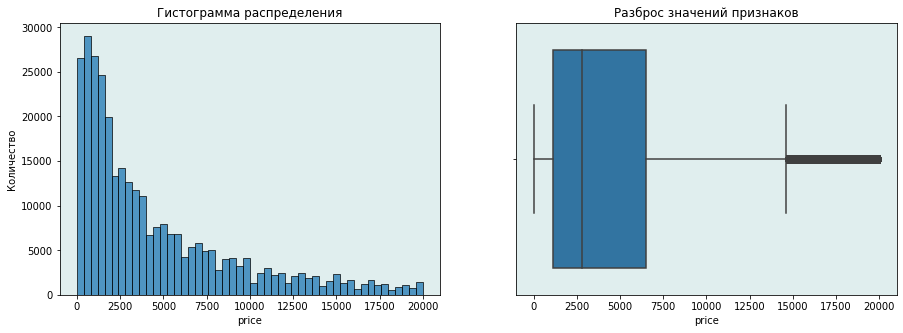

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


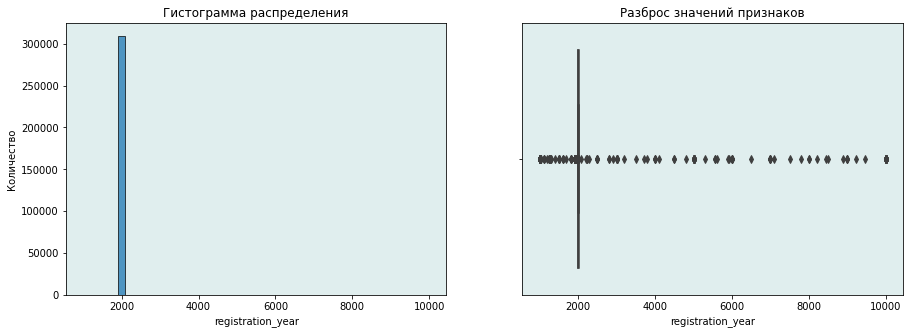

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


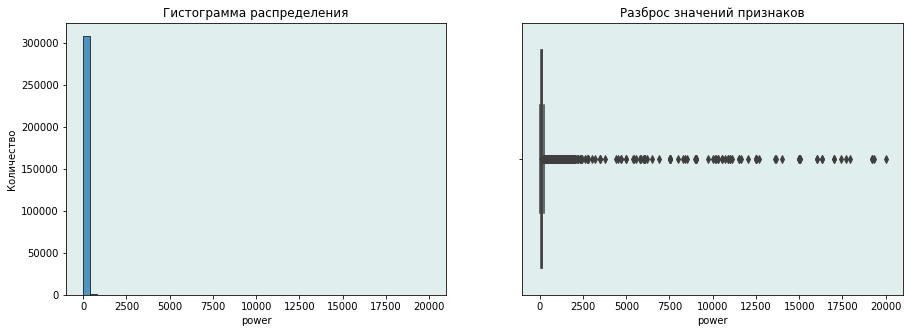

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


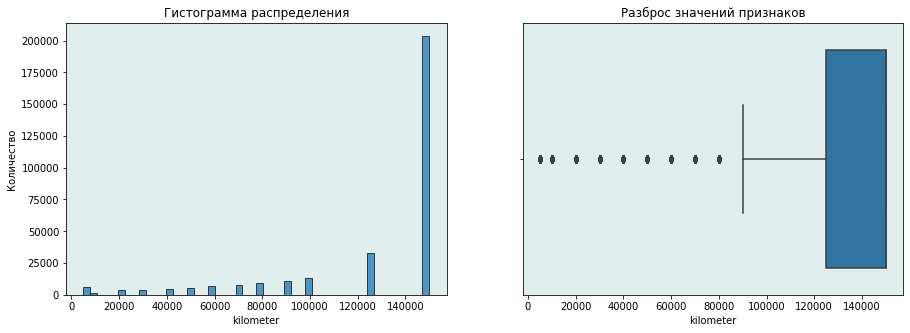

In [14]:
def hist_boxplot(df, column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
    sns.histplot(data=df, x=column, ax=axes[0], bins=50)
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(column)
    axes[0].set_facecolor('#E0EEEE')
    
    sns.boxplot(df[column], ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_facecolor('#E0EEEE')
      
    plt.show()
    
for column in list(num_columns):
    hist_boxplot(df, column)

**Видим явные проблемы со значениями в столбце год регистрации автомобиля и мощность двигателя, а так же есть объявления со стоимостью автомобиля = 0. Это аномалии, от них нужно избавляться. Среди серийных автомобилей в 2017 году с самым мощным двигателем был автомобиль `Dodge Challenger SRT Demon` с 840 лошадками под капотом. Это значение и примем за верхнюю границу.**

**Проверим целевой признак, отсортировав столбец `price` по возрастанию.**

In [15]:
display(df['price'].sort_values(ascending=True))
print('Количество объявлений со стоимостью автомобиля менее 100 евро:', df[df['price'] < 100].value_counts().sum())

171984        0
254093        0
14098         0
184347        0
79021         0
          ...  
230017    20000
35837     20000
25663     20000
28009     20000
26824     20000
Name: price, Length: 309329, dtype: int64

Количество объявлений со стоимостью автомобиля менее 100 евро: 11281


In [16]:
df = df.query('power > 40 and power <= 840')
df = df.query('registration_year > 1960 and registration_year <= 2016 and price >= 100')

In [17]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254767 entries, 1 to 309328
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              254767 non-null  int64 
 1   vehicle_type       254767 non-null  object
 2   registration_year  254767 non-null  int64 
 3   gearbox            254767 non-null  object
 4   power              254767 non-null  int64 
 5   model              254767 non-null  object
 6   kilometer          254767 non-null  int64 
 7   fuel_type          254767 non-null  object
 8   brand              254767 non-null  object
 9   repaired           254767 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.4+ MB


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes


In [18]:
print('Всего удалённо объектов:', df_shape - df.shape[0]) 
print(f'Доля удалённых объектов: {round((1 - df.shape[0] / df_shape)*100, 2)}%') 

Всего удалённо объектов: 99602
Доля удалённых объектов: 28.11%


**Удалили четверть данных. Наверное много, но я старался как можно меньше вносить изменений в данные, чтобы не навредить качеству обучения моделей.**

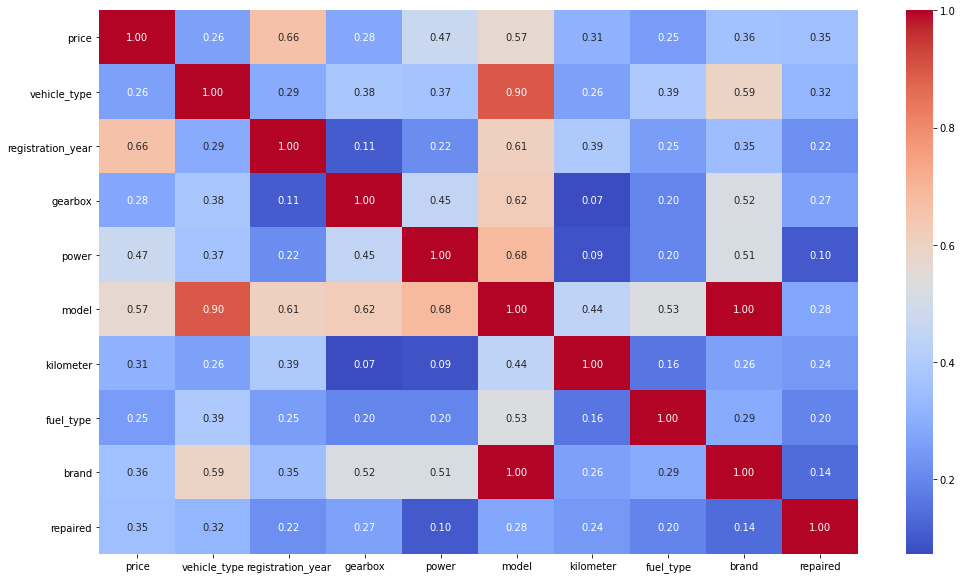

In [19]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(df.phik_matrix(interval_cols=['price', 
                                          'registration_year', 
                                          'power', 
                                          'kilometer']), 
            annot=True, fmt='.2f', cmap='coolwarm');

**Признак `model` коррелирует с признаками `brand` и `vehicle_type` уберем его.**

In [20]:
df = df.drop('model', axis = 1)

**Вывод.**
**Загружены данные, проверены на наличие дубликатов. Пропуски обработаны заглушками, аномалии удалены. Датасет готов для обучения моделей.**

## Обучение моделей

In [21]:
features = df.drop(['price'], axis=1)
target = df['price']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size = 0.6, random_state = 29)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=29)

In [22]:
X_train.head()

,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
16806,wagon,2001,auto,170,150000,petrol,audi,unknown
304698,wagon,2009,manual,177,150000,gasoline,bmw,yes
268185,unknown,2016,manual,60,150000,unknown,volkswagen,no
213176,small,2014,manual,69,30000,petrol,opel,no
211971,sedan,1991,manual,150,150000,petrol,bmw,no


In [23]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']
del df

In [24]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_val_ohe = encoder.transform(X_val[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_val_ohe = pd.DataFrame(X_val_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_val_scaled = scaler.transform(X_val[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_val = pd.concat([X_val_ohe, X_val_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train[:5]

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_manual,x1_unknown,...,x3_suzuki,x3_toyota,x3_trabant,x3_volkswagen,x3_volvo,x4_unknown,x4_yes,registration_year,power,kilometer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.307982,0.875464,0.605328
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.937200,1.004070,0.605328
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.026735,-1.145488,0.605328
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.715439,-0.980138,-2.633480
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.864460,0.508018,0.605328


**Модель LinearRegression**

In [25]:
start_time = time.time()
model = LinearRegression()
model.fit(X_train, y_train)
lr_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % lr_train_time)

start_time = time.time()
pred = model.predict(X_val)
lr_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % lr_pred_time)

rmse_lr_model = mean_squared_error(y_val, pred, squared=False)
print(f'RMSE = {rmse_lr_model:.3f}')

---Время обучения модели 2.5043 секунд ---
---Время прогноза модели 0.1816 секунд ---
RMSE = 2755.065


**Модель DecisionTreeRegressor**

In [26]:
start_time = time.time()

model = DecisionTreeRegressor(random_state=29)
model.fit(X_train, y_train)
dtr_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % dtr_train_time)

start_time = time.time()
pred = model.predict(X_val)
dtr_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % dtr_pred_time)

rmse_model_dtr = mean_squared_error(y_val, pred, squared=False)
print(f'RMSE = {rmse_model_dtr:.3f}')

---Время обучения модели 1.3219 секунд ---
---Время прогноза модели 0.02676 секунд ---
RMSE = 2021.467


In [27]:
def rmse(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    score = np.sqrt(((y_pred - y_true) ** 2).mean())
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

start_time = time.time()
pipe_final = Pipeline(
    [
        ('models', DecisionTreeRegressor(random_state=29))
    ]
)

param_grid = [

    {
        'models__max_depth': range(1, 25),
        'models__max_features': range(1, 25),
        'models__min_samples_leaf': range(1, 25)
    }
]
rs = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=rmse_score, n_jobs=-1, random_state=29, refit='rmse_score')

rs.fit(X_train, y_train)
rs_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % rs_pred_time)

start_time = time.time()
y_val_pred = rs.predict(X_val)
print(f'Метрика на валидационной выборке: {round(rmse(y_val, y_val_pred), 4)}')
print('Лучшая модель и её параметры:\n', rs.best_estimator_)
print('Метрика для лучшей модели на кросс-валидационной выборке: ', round((-rs.best_score_), 4))

---Время прогноза модели 7.87628 секунд ---
Метрика на валидационной выборке: 2028.9418
Лучшая модель и её параметры:
 Pipeline(steps=[('models',
                 DecisionTreeRegressor(max_depth=21, max_features=13,
                                       min_samples_leaf=3, random_state=29))])
Метрика для лучшей модели на кросс-валидационной выборке:  2028.6808


**Модель CatBoostRegressor**

In [28]:
start_time = time.time()
model = CatBoostRegressor(learning_rate=0.5, random_state=29, verbose=False)
model.fit(X_train, y_train)
cat_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % cat_train_time)

start_time = time.time()
pred = model.predict(X_val)
cat_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % cat_pred_time)

rmse_cat_boost_model = mean_squared_error(y_val, pred, squared=False)
print(f'RMSE = {rmse_cat_boost_model:.3f}')

---Время обучения модели 19.0841 секунд ---
---Время прогноза модели 0.05638 секунд ---
RMSE = 1635.848


**Модель LightGBM**

In [29]:
start_time = time.time()
model = LGBMRegressor(learning_rate=0.1, num_leaves=50, random_state=29)
model.fit(X_train, y_train)
lgbm_train_time = round((time.time() - start_time), 5)
print("---Время обучения модели %s секунд ---" % lgbm_train_time)
start_time = time.time()
pred = model.predict(X_val)
lgbm_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % lgbm_pred_time)

rmse_light_gbm_model = mean_squared_error(y_val, pred, squared=False)
print(f'RMSE = {rmse_light_gbm_model:.3f}')

---Время обучения модели 53.71365 секунд ---
---Время прогноза модели 0.49914 секунд ---
RMSE = 1681.577


## Анализ моделей

In [30]:
data = [[lr_train_time, lr_pred_time, rmse_lr_model],
        [dtr_train_time, dtr_pred_time, rmse_model_dtr],
        [lgbm_train_time, lgbm_pred_time, rmse_light_gbm_model],
        [cat_train_time, cat_pred_time, rmse_cat_boost_model]]
models = ['linear_regression', 'decision_tree_regressor', 'LightGBM', 'CatBoostRegressor']
resume = pd.DataFrame(data=data, index=models, columns=['Время обучения модели', 'Время прогноза модели', 'RMSE'])
resume

,Время обучения модели,Время прогноза модели,RMSE
linear_regression,2.50430,0.18160,2755.064898
decision_tree_regressor,1.32190,0.02676,2021.467344
LightGBM,53.71365,0.49914,1681.577166
CatBoostRegressor,19.08410,0.05638,1635.847587


**`CatBoostRegressor` показала лучшее значение метрики RMSE среди всех моделей. Обучение, конечно, долгое, модель требовательна к вычислительным ресурсам, зато предсказывает более точно, что важно для бизнеса.**

**Проверка лучшей модели на тестовой выборке.**

In [32]:
start_time = time.time()
model = CatBoostRegressor(learning_rate=0.5, random_state=29, verbose=False)
model.fit(X_train, y_train)
cat_train_time = round((time.time() - start_time), 5)
print('---Время обучения модели %s секунд ---' % cat_train_time)

start_time = time.time()
pred = model.predict(X_test)
cat_pred_time = round((time.time() - start_time), 5)
print('---Время прогноза модели %s секунд ---' % cat_pred_time)

rmse_cat_boost_model = mean_squared_error(y_test, pred, squared=False)
print(f'RMSE = {rmse_cat_boost_model:.3f}')

---Время обучения модели 18.96997 секунд ---
---Время прогноза модели 0.05752 секунд ---
RMSE = 1632.496


**Модель неплохо справилась. Все критерии выполнены.**